## Reference Car Predictions: Spline vs Linear

Compare predicted prices for the same car configurations across both models.
This shows how nonlinear spline effects change price estimates vs the linear model.

In [ ]:
# Visualize and quantify color premiums
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

az.plot_forest(idata_spline_color, var_names=["1|color_category"], combined=True, ax=axes[0])
axes[0].set_title("Spline Model: Color Category Effects")

az.plot_forest(idata_hierarchical_color, var_names=["1|color_category"], combined=True, ax=axes[1])
axes[1].set_title("Hierarchical Model: Color Category Effects")

plt.tight_layout()

# Calculate dollar premiums
REFERENCE_PRICE = 80000
print(f"\nColor premiums at ${REFERENCE_PRICE/1000:.0f}k reference price:\n")

for name, idata in [("Spline", idata_spline_color), ("Hierarchical", idata_hierarchical_color)]:
    print(f"{name} Model:")
    std_effect = idata.posterior["1|color_category"].sel(
        {"color_category__factor_dim": "standard"}
    ).values.flatten()

    for cat in ["special", "PTS", "unknown"]:
        cat_effect = idata.posterior["1|color_category"].sel(
            {"color_category__factor_dim": cat}
        ).values.flatten()
        premium = REFERENCE_PRICE * (np.exp(cat_effect - std_effect) - 1)
        print(
            f"  {cat} vs standard: ${np.median(premium):+,.0f} "
            f"[${np.percentile(premium, 5):+,.0f}, ${np.percentile(premium, 95):+,.0f}]"
        )
    print()

In [ ]:
# Build and fit hierarchical model with color
hierarchical_model_color = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
    include_color=True,
)

idata_hierarchical_color = fit_model(
    hierarchical_model_color,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

In [ ]:
# Build and fit spline model with color
spline_model_color = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_color=True,
)

idata_spline_color = fit_spline_model(
    spline_model_color,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

In [ ]:
# Color category distribution and price breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count by category
color_counts = df_cleaned["color_category"].value_counts()
sns.barplot(x=color_counts.index, y=color_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Listings by Color Category")
axes[0].set_ylabel("Count")
for i, v in enumerate(color_counts.values):
    axes[0].text(i, v + 10, str(v), ha="center")

# Price by category
sns.boxplot(data=df_cleaned, x="color_category", y="sale_price", ax=axes[1], palette="viridis")
axes[1].set_title("Price Distribution by Color Category")
axes[1].set_ylabel("Sale Price ($)")
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"${x/1000:.0f}k"))

plt.tight_layout()

# Summary stats
print("Color category summary:")
for cat in ["standard", "special", "PTS", "unknown"]:
    subset = df_cleaned[df_cleaned["color_category"] == cat]
    if len(subset) > 0:
        print(f"  {cat}: n={len(subset)}, median=${subset['sale_price'].median():,.0f}")

## Color Category Analysis

Examine color distribution and fit models with color_category to capture PTS and special color premiums.

In [ ]:
# Forest plots comparing random effects between models
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|generation"],
    combined=True,
    ax=axes[0, 0],
)
axes[0, 0].set_title("Generation Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|trim_tier"],
    combined=True,
    ax=axes[0, 1],
)
axes[0, 1].set_title("Trim Tier Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|trans_type"],
    combined=True,
    ax=axes[1, 0],
)
axes[1, 0].set_title("Transmission Effects")

az.plot_forest(
    [idata_spline, idata_hierarchical],
    model_names=["Spline", "Hierarchical"],
    var_names=["1|body_style"],
    combined=True,
    ax=axes[1, 1],
)
axes[1, 1].set_title("Body Style Effects")

plt.tight_layout()

# 04 - Spline Effects Model

This notebook explores nonlinear effects of age and mileage using B-splines,
while retaining partial pooling (random intercepts) on categorical predictors.

**Model comparison:**
| Model | Continuous | Categoricals |
|-------|------------|---------------|
| Hierarchical | Linear age + random slope by gen | Random intercepts |
| Spline | `bs(age)` + `bs(mileage_scaled)` | Random intercepts |

In [ ]:
import logging
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from price_analysis.data.cleaning import prepare_model_data
from price_analysis.models import (
    build_model,
    build_spline_model,
    compare_models_loo,
    compare_residual_stats,
    fit_model,
    fit_spline_model,
    get_residuals,
    plot_residual_diagnostics,
    plot_spline_effects_grid,
)
from price_analysis.models.hierarchical import check_diagnostics, predict_price
from price_analysis.models.spline import predict_spline_price

logging.basicConfig(level=logging.INFO)
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
DATA_DIR = Path("../data")
PROCESSED_PATH = DATA_DIR / "processed" / "cleaned_listings.parquet"

## Load and Prepare Data

In [3]:
df_cleaned = pd.read_parquet(PROCESSED_PATH)
df = prepare_model_data(df_cleaned, group_trims=True, group_trans=True)

MILEAGE_MEAN, MILEAGE_STD = df_cleaned["mileage"].mean(), df_cleaned["mileage"].std()

print(f"Model data: {len(df)} listings")
print(f"Age range: {df['age'].min()} - {df['age'].max()} years")
print(
    f"Mileage range (scaled): {df['mileage_scaled'].min():.2f} - {df['mileage_scaled'].max():.2f}"
)

INFO:price_analysis.data.cleaning:Grouped trims into tiers: {'sport': 392, 'base': 360, 'turbo': 272, 'gt': 148, 'gts': 100, 'rs': 88}
INFO:price_analysis.data.cleaning:Grouped transmissions into types: {'manual': 790, 'pdk': 476, 'auto': 94}
INFO:price_analysis.data.cleaning:Model-ready dataset: 1360 listings (from 1615 cleaned)


Model data: 1360 listings
Age range: 0.0 - 26.0 years
Mileage range (scaled): -1.05 - 5.03


## Build Spline Model

In [4]:
AGE_DF = 4  # Degrees of freedom for age spline
MILEAGE_DF = 4  # Degrees of freedom for mileage spline
INCLUDE_SALE_YEAR = False  # All 2025 listings
TARGET_ACCEPT = 0.975

In [5]:
spline_model = build_spline_model(
    df,
    age_df=AGE_DF,
    mileage_df=MILEAGE_DF,
    include_sale_year=INCLUDE_SALE_YEAR,
)
print(spline_model)

INFO:price_analysis.models.spline:Spline model formula: log_price ~ 1 + bs(age, df=4) + bs(log_mileage, df=4) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.spline:Built spline model with 1360 observations


       Formula: log_price ~ 1 + bs(age, df=4) + bs(log_mileage, df=4) + (1 | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 8.3392)
            bs(age, df=4) ~ Normal(mu: [0. 0. 0. 0.], sigma: [ 9.9863 11.816   8.5029  7.417 ])
            bs(log_mileage, df=4) ~ Normal(mu: [0. 0. 0. 0.], sigma: [15.8365 15.0214  9.2876 20.8461])
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.8229)


## Fit Spline Model

In [6]:
%%time
idata_spline = fit_spline_model(
    spline_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.spline:Fitting spline model: 1000 draws, 1000 tune, 8 chains
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, bs(age, df=4), bs(log_mileage, df=4), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, bs(age, df=4), bs(log_mileage, df=4), 1|generation_sigma, 1|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 106 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 106 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.spline:Model summary:
                            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                      0.199  0.004   0.191    0.206      0.000    0.000   
Intercept                 12.277  0.307  11.711   12.864      0.005    0.004   
bs(age, df=4)[0]           0.281  0.117   0.063    0.508      0.001    0.001   

CPU times: user 8.33 s, sys: 871 ms, total: 9.21 s
Wall time: 1min 52s


## Diagnostics

In [7]:
diagnostics = check_diagnostics(idata_spline)
print(f"Converged: {diagnostics['converged']}")
print(f"Divergences: {diagnostics['n_divergences']}")
print(f"Max R-hat: {diagnostics['rhat_max']:.3f}")
print(f"Min ESS (bulk): {diagnostics['ess_bulk_min']:.0f}")
if diagnostics["issues"]:
    print(f"Issues: {diagnostics['issues']}")

Converged: False
Divergences: 1
Max R-hat: 1.000
Min ESS (bulk): 2554
Issues: ['1 divergences detected']


/var/folders/hm/9dvmv29n6kvb69cldng_vjxc0000gq/T/ipykernel_21686/1043550508.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


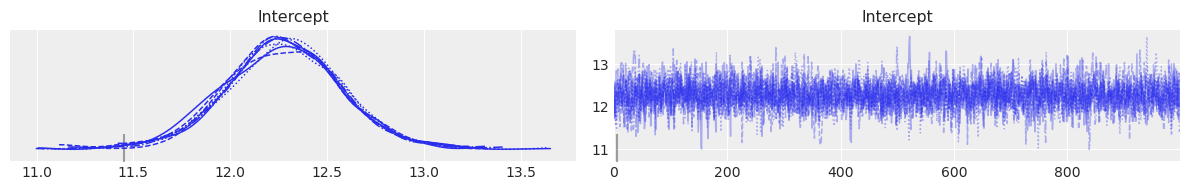

In [8]:
var_names = ["Intercept"]
az.plot_trace(idata_spline, var_names=var_names)
plt.tight_layout()

## Visualize Spline Effects

These plots show the estimated nonlinear relationship between age/mileage and log(price),
holding other variables at their median/mode values.

/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/spline.py:298: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Text(0.5, 1.02, 'Spline Effects on log(price)')

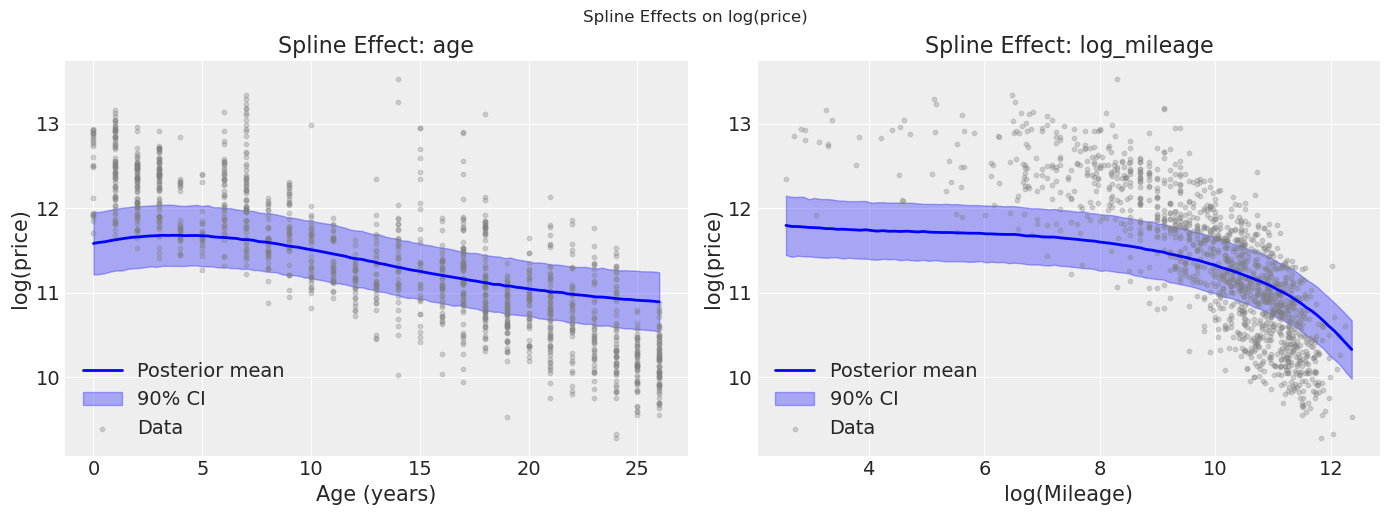

In [9]:
fig = plot_spline_effects_grid(spline_model, idata_spline, df)
fig.suptitle("Spline Effects on log(price)", y=1.02)

## Fit Hierarchical Model for Comparison

In [10]:
hierarchical_model = build_model(
    df,
    include_sale_year=INCLUDE_SALE_YEAR,
    include_generation_slope=True,
    use_trim_tier=True,
    use_trans_type=True,
)
print(hierarchical_model)

INFO:price_analysis.models.hierarchical:Model formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
INFO:price_analysis.models.hierarchical:Built model with 1360 observations


       Formula: log_price ~ 1 + age + mileage_scaled + is_low_mileage + (1 + age | generation) + (1 | trim_tier) + (1 | trans_type) + (1 | body_style)
        Family: gaussian
          Link: mu = identity
  Observations: 1360
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 11.3507, sigma: 2.0573)
            age ~ <function _truncated_normal_upper at 0x16b868680>(sigma: 0.05)
            mileage_scaled ~ <function _truncated_normal_upper at 0x16b868680>(sigma: 0.3)
            is_low_mileage ~ <function _truncated_normal_lower at 0x16b868720>(sigma: 0.2)
        
        Group-level effects
            1|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.5))
            age|generation ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.1))
            1|trim_tier ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.7))
            1|trans_type ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.3))
            1|body_style ~ Normal(mu: 0.0, sigma: HalfN

In [11]:
%%time
idata_hierarchical = fit_model(
    hierarchical_model,
    draws=1000,
    tune=1000,
    chains=8,
    cores=8,
    target_accept=TARGET_ACCEPT,
)

INFO:price_analysis.models.hierarchical:Fitting model: 1000 draws, 1000 tune, 8 chains, target_accept=0.975
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
INFO:pymc.sampling.mcmc:Multiprocess sampling (8 chains in 8 jobs)
NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]
INFO:pymc.sampling.mcmc:NUTS: [sigma, Intercept, age, mileage_scaled, is_low_mileage, 1|generation_sigma, 1|generation_offset, age|generation_sigma, age|generation_offset, 1|trim_tier_sigma, 1|trim_tier_offset, 1|trans_type_sigma, 1|trans_type_offset, 1|body_style_sigma, 1|body_style_offset]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.
INFO:pymc.sampling.mcmc:Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 110 seconds.
/opt/homebrew/Caskroom/miniconda/base/envs/price-analysis/lib/python3.12/site-packages/arviz/utils.py:146: UserWarning: Items starting with ~: ['1|', 'age|'] have not been found and will be ignored
  warnings.warn(
INFO:price_analysis.models.hierarchical:Model summary:
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
sigma                     0.200  0.004   0.193    0.208      0.000    0.000   
Intercept                11.860  0.299  11.284   12.417      0.005    0.004   
age                      -0.027  0.009  -0.043   -0.008      0.000    0.000   
mileage_scaled           -0.215  0.008  -0.229   -0.199      0.000    0.000   
is_low_mileage            0.164  0.020   0.125    0.201      0.000    0.000   
1|generation_sigma    

CPU times: user 8.54 s, sys: 692 ms, total: 9.24 s
Wall time: 1min 52s


## LOO-CV Model Comparison

Compare models using Leave-One-Out Cross-Validation (PSIS-LOO).
Higher ELPD = better out-of-sample predictive performance.

In [12]:
comparison = compare_models_loo(
    {
        "hierarchical (linear + random slopes)": idata_hierarchical,
        "spline (bs age/mileage + random intercepts)": idata_spline,
    }
)
display(comparison)

INFO:price_analysis.models.comparison:Model comparison (ic=loo):
                                             rank    elpd_loo      p_loo  \
spline (bs age/mileage + random intercepts)     0  252.171023  32.110779   
hierarchical (linear + random slopes)           1  242.911234  27.078564   

                                             elpd_diff    weight         se  \
spline (bs age/mileage + random intercepts)   0.000000  0.603486  48.277660   
hierarchical (linear + random slopes)         9.259789  0.396514  50.582718   

                                                 dse  warning scale  
spline (bs age/mileage + random intercepts)  0.00000    False   log  
hierarchical (linear + random slopes)        9.02973    False   log  


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
spline (bs age/mileage + random intercepts),0,252.171023,32.110779,0.000000,0.603486,48.277660,0.00000,False,log
hierarchical (linear + random slopes),1,242.911234,27.078564,9.259789,0.396514,50.582718,9.02973,False,log


Text(0.5, 1.0, 'Model Comparison (LOO-CV)')

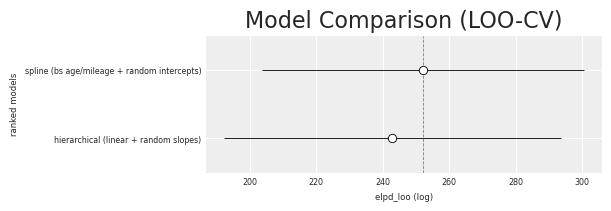

In [13]:
az.plot_compare(comparison)
plt.title("Model Comparison (LOO-CV)")

## Residual Comparison

Compare residual patterns to see if the spline model better captures
nonlinear relationships that the linear model misses.

In [14]:
residuals_hierarchical = get_residuals(hierarchical_model, idata_hierarchical, df)
residuals_spline = get_residuals(spline_model, idata_spline, df)

residuals_dict = {
    "Hierarchical": residuals_hierarchical,
    "Spline": residuals_spline,
}

In [15]:
stats_df = compare_residual_stats(residuals_dict)
display(stats_df.round(4))

,rmse,mae,mean,std,median,iqr
Hierarchical,0.1987,0.1444,-0.0001,0.1988,-0.0157,0.2201
Spline,0.1966,0.1442,-0.0001,0.1967,-0.0079,0.2178


/Users/flatljan/personal/price-trend-analysis/src/price_analysis/models/comparison.py:231: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


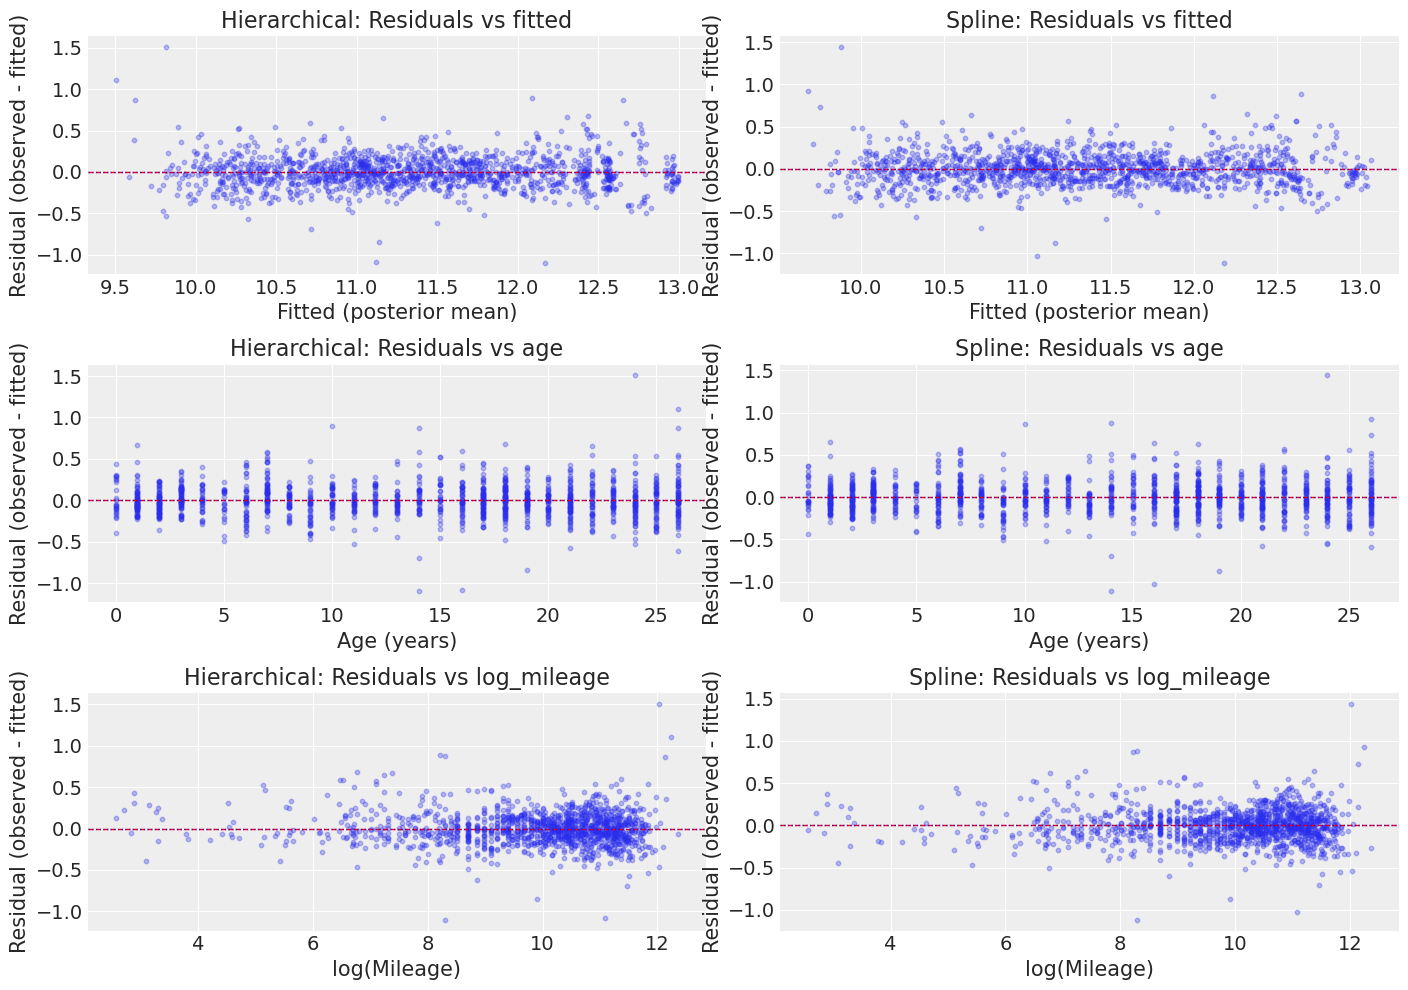

In [16]:
fig = plot_residual_diagnostics(residuals_dict)

## Random Effects Analysis

Compare the random intercept estimates between spline and hierarchical models.
Both share the same random effect structure for generation, trim, transmission, and body style.

## Degrees of Freedom Sensitivity

Quick check: does the number of spline basis functions matter much?

In [17]:
# Compare df=3 vs df=5 (optional - can be slow)
# Uncomment to run sensitivity analysis

# df_sensitivity = {}
# for df_val in [3, 5]:
#     model = build_spline_model(df, age_df=df_val, mileage_df=df_val, include_sale_year=False)
#     idata = fit_spline_model(model, draws=1000, tune=500, chains=4)
#     df_sensitivity[f"df={df_val}"] = idata

# df_sensitivity["df=4"] = idata_spline
# sensitivity_comparison = compare_models_loo(df_sensitivity)
# display(sensitivity_comparison)

## Summary

**Key findings:**

1. **Spline effects**: [interpret the shape of age/mileage curves]

2. **Model comparison**: [ELPD difference and interpretation]

3. **Residuals**: [any patterns resolved by splines?]

**Recommendations:**

- [which model to prefer for inference vs prediction?]
- [any follow-up analyses needed?]